In [1]:
# Importing the neccessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl

from scipy import stats

import networkx as nx
import powerlaw

import collections
import random
import heapq

import math
from math import pi

C:\Users\Domonkos\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Domonkos\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Domonkos\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Functions
#### Function for getting all the coordinates of a line between two points

In [2]:
def intermediates(p1, p2, nb_points=8):
    
    x_spacing = (p2[0] - p1[0]) / (nb_points + 1)
    y_spacing = (p2[1] - p1[1]) / (nb_points + 1)

    return [[p1[0] + i * x_spacing, p1[1] +  i * y_spacing] 
            for i in range(1, nb_points+1)]

#### Function for calculating the polar coordinates from the Cartesian coordinates

In [3]:
def polar_coord(x, y):
    
    r = np.sqrt(x**2 + y**2)
    
    if y >= 0 and r != 0:
        theta = math.acos(x/r)
    elif y < 0:
        theta = -math.acos(x/r)
        
    return [r, theta]

#### Function for calculating the radial dst

In [4]:
def radial_dst(theta1, theta2):
    
        dst1 = abs(theta1 - theta2)
        dst2 = abs(2*math.pi - dst1)
        
        if dst1 < dst2:
            return dst1
        else:
            return dst2

## Generating the circle

In [5]:
# Setting the parameters of the circle

t = np.array(range(0,int(round(2*math.pi, 3)*1000)))/1000
r = 1
a = 0
b = 0

# Creating the circle circumf.

circumf_x = r * np.array([math.cos(i) for i in t]) + a
circumf_y = r * np.array([math.sin(i) for i in t]) + b

In [6]:
# Getting all the inner points of the circle

inner_coord = []

for i in range(0,len(circumf_x)):
    inner_coord += intermediates([0,0], [circumf_x[i],circumf_y[i]], 100)
    
# Transforming the inner_coord list of lists into np.array

inner_x = np.array(inner_coord).T[0]
inner_y = np.array(inner_coord).T[1]

# Appending all the x and y coordinates together

all_x_coord = list(circumf_x) + list(inner_x)
all_y_coord = list(circumf_y) + list(inner_y)

In [7]:
# Generating the polar coordinates from the Cartesian coordinates

r_values = []
theta_values = []

for i in range(0,len(all_x_coord)):
    
    temp = polar_coord(all_x_coord[i], all_y_coord[i])
    
    r_values.append(temp[0])
    theta_values.append(temp[1])

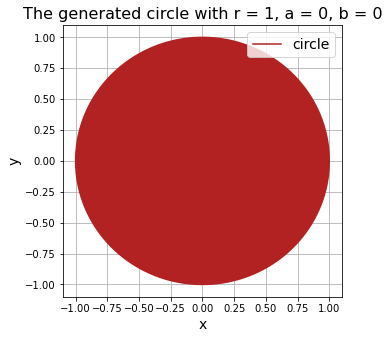

In [8]:
# Plotting the circle

plt.figure(figsize = (5,5))
plt.plot(all_x_coord, all_y_coord, color = 'firebrick', label = 'circle')

plt.title('The generated circle with r = ' + str(r) + ', a = ' + str(a) + ', b = ' + str(b), fontsize = 16)
plt.xlabel('x', fontsize = 14)
plt.ylabel('y', fontsize = 14)

plt.legend(fontsize = 14)
plt.grid()
plt.show()

# Functions

### Function for generating and adding nodes to the circle

In [62]:
def generating_circle(new_num_nodes_to_generate, T, beta, m, zeta): 

    # Creating lists to save the generated coordinates and probabilities of connections
    generated_coordinates = []
    
    # Creating lists for the r, theta and nodes
    r_list = []
    theta_list = []
    node_list = []

    # Generating the first random coordinates
    
    r_list.append(2/zeta*math.log(1))
    theta = np.random.uniform(0,int(2*math.pi*10000))/10000 - math.pi
    theta_list.append(theta) 
    node_list.append(1)
    
    # Generating N coordinates

    for i in range(2, new_num_nodes_to_generate):
        
        #
        x_st_list = []
        prob_connection = []
        
        #new r and theta
        r = 2/zeta*math.log(i)
        while theta in theta_list:
            theta = np.random.uniform(0,int(2*math.pi*1000000))/1000000# - math.pi
        
        #appending the values
        r_list.append(r)
        theta_list.append(theta)
        node_list.append(i)
        
        #updating the r values
        for j in range(0,len(r_list)-1):
            
            #calculating the new r values
            r_list[j] = beta*r_list[j] + (1 - beta)*r        
        
            #calculating the R_i
            if beta < 1:
                R_i = r - (2/zeta) * math.log( (2*T / math.sin(T*math.pi)) * (1 - math.exp((zeta/2) * (beta-1) * r))/(m * (1 - beta)))
            elif beta == 1:
                R_i = r - (2/zeta) * math.log( (2*T / math.sin(T*math.pi)) * zeta*r/m)
                
            #calculating the probability of connection
            #print(radial_dst(theta_list[j], theta))
            x_st = r + r_list[j] + (2/zeta)*math.log(radial_dst(theta_list[j], theta)/2)
            p_st = (1 / (1 + math.exp((x_st - R_i) * zeta / (2*T) )))
            
            #appending the probabilities to a list
            #x_st_list.append([x_st, (j, i)])
            prob_connection.append([p_st, (j+1, i)])

    
        #filtering out the highest probabilities and appending to the generated_coordinates
        temp_largest_values = heapq.nlargest(m, prob_connection)
        for kk in range(0,len(temp_largest_values)):
            generated_coordinates.append(temp_largest_values[kk])
        #temp_largest_values_xst = heapq.nsmallest(m, x_st_list)
        #for kk in range(0,len(temp_largest_values_xst)):
        #    generated_coordinates.append(temp_largest_values_xst[kk])

    return [generated_coordinates, [r_list, theta_list, node_list]]

### Function for generating a corresponding network

In [10]:
def network_gen(nodes, edges):

    # Creating the graph

    circle_graph = nx.Graph()

    # Adding the nodes

    for i in range(0,len(nodes)):
        circle_graph.add_node(nodes[i])

    # Adding the weights

    for i in range(0,len(edges.T)):
        circle_graph.add_edge(edges[0][i], edges[1][i])
        
    return circle_graph

### Function for plotting the network layout

In [11]:
def network_plot(graph):

    # Plotting the graph

    plt.figure(figsize = (9,9))

    # Setting the layout

    pos_cust = nx.kamada_kawai_layout(graph)

    # Drawing the graph

    nx.draw(graph, pos = pos_cust, node_color = 'firebrick', node_size=10, width = 0.5)

    #plt.savefig('network_layout_circle.jpg', dpi=400)

### Function for power law distribution and plotting

In [12]:
def powerlaw_plotting(graph, name):
    
    # Power law distribution and clust coeff
    fit = powerlaw.Fit(np.array(nx.degree(graph)).T[1])
    clust = np.mean(list(nx.clustering(graph).values()))
    
    # Printing the clust coeff and power law alpha value
    print("\nClustering coefficient: ", clust)
    print("Powerlaw coefficient: gamma =", fit.power_law.alpha, "\n")

    # Plotting the results
    plt.figure(figsize=(10,7))

    fit.power_law.plot_pdf(color = 'orange', linestyle='--', label='fit ccdf')
    fit.plot_pdf(color = 'black', label = 'original')

    plt.title("Probability density function of the " + name + " - powerlaw fitting", fontsize = 14)
    plt.xlabel("Degree", fontsize = 14)
    plt.ylabel("Probability", fontsize = 14)

    plt.legend(fontsize = 15)
    plt.grid()
    
    #plt.savefig(name + "_powerlaw_fit.jpg", dpi = 400)
    
    plt.show()

### Function for printing the gamma - beta relation

In [13]:
def gamma_beta_print(gamma_list, beta_list, y_lower, y_upper, x_lower, x_upper, save_img):
    
    # Calculating the theoretical values
    
    theoretical_gamma_list = 1 + 1/np.array(beta_list)
    
    # Plotting the results
    
    plt.figure(figsize = (10,7))
    
    plt.scatter(beta_list, gamma_list, color = 'black', label = 'fitted values', linewidths = 0.1)
    plt.plot(beta_list, theoretical_gamma_list, color = 'orange', label = 'theoretical values')
    
    plt.title('Theoretical and actual values of gamma in function of beta.', fontsize = 18)
    plt.xlabel('Beta values', fontsize = 14)
    plt.ylabel('Gamma values', fontsize = 14)
    
    plt.ylim(y_lower,y_upper)
    plt.xlim(x_lower, x_upper)
    
    plt.grid()
    plt.legend(fontsize = 15)
    
    if save_img == True:
        plt.savefig("beta_gamma_relation.jpg", dpi = 400)
    
    plt.show()

### Creating a function for calculating the degree distribution

In [14]:
def plot_degree_histogram(g, normalized=False):

    aux_y = nx.degree_histogram(g)
    aux_x = np.arange(0,len(aux_y)).tolist()
    n_nodes = g.number_of_nodes()
    
    if normalized:
        for i in range(len(aux_y)):
            aux_y[i] = aux_y[i]/n_nodes
    
    return aux_x, aux_y

In [15]:
def network_gen2(nodes, edges):

    # Creating the graph

    circle_graph = nx.Graph()

    # Adding the nodes

    for i in range(0,len(nodes)):
        circle_graph.add_node(nodes[i])

    # Adding the weights

    for i in range(0,len(edges)):
        circle_graph.add_edge(edges[i][0], edges[i][1])
        
    return circle_graph

# Calling the functions - generating the PSO network

In [16]:
# Plot for the power law distribution
#powerlaw_plotting(circle_network, 'PSO')

# Plotting the gamma-beta distribution
#gamma_beta_print(gamma_values, beta_values)

# Plotting the generated network
#network_plot(circle_network)

# Plotting the circle 
#mpl.rcParams['agg.path.chunksize'] = 600
#circle_plot(new_num_nodes_to_generate, inner_x, inner_y, circumf_x, circumf_y, coordinates)

# Plotting the results for calculating the attractiveness - k function
#attr_k_plot(attractiveness_calc(circle_network)[0], attractiveness_calc(circle_network)[1])

<ipython-input-97-3a9a9c099204>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  edges = np.array(generated_coordinates).T[1]
Calculating best minimal value for power law fit
C:\Users\Domonkos\anaconda3\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


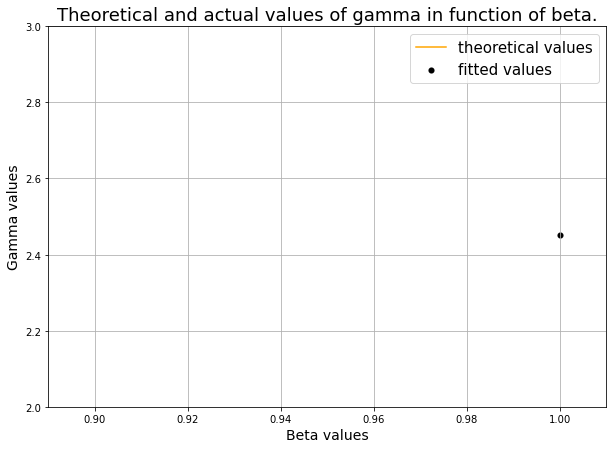

In [97]:
# Setting some variables

new_num_nodes_to_generate = 1000

m = 2
T = 0.9
zeta = 1
#beta_values = np.array(range(90,101))/100
beta_values = [1]

# Creating list to store gamma values

gamma_values = []

for betas in beta_values:

    # Calling the coordinates function

    coordinates_temp = generating_circle(new_num_nodes_to_generate, T, betas, m, zeta)

    # Extracting the values

    generated_coordinates = coordinates_temp[0]
    #edges = np.array(list(np.array(generated_coordinates).T[1])).T
    edges = np.array(generated_coordinates).T[1]
    #r_values = coordinates_temp[1][0]
    #theta_values = coordinates_temp[1][1]
    nodes = coordinates_temp[1][2]

    # Generating the actual network
    circle_network = network_gen2(nodes, edges)
    
    # Calculating the power law value
    fit = powerlaw.Fit(np.array(nx.degree(circle_network)).T[1])
    gamma_values.append(fit.power_law.alpha)
    
    
# Plotting the gamma-beta distribution

y_lower = 2
y_upper = 3

x_lower = 0.89
x_upper = 1.01

save_img = False

gamma_beta_print(gamma_values, beta_values, y_lower, y_upper, x_lower, x_upper, save_img)

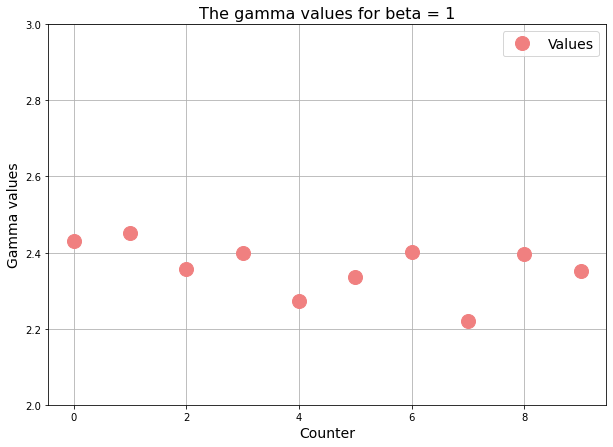

In [115]:
plt.figure(figsize = (10,7))
plt.plot(gamma_vals, 'o', markersize = 14, color = 'lightcoral', label = 'Values')

plt.title('The gamma values for beta = 1', fontsize = 16)
plt.xlabel('Counter', fontsize = 14)
plt.ylabel('Gamma values', fontsize = 14)

plt.ylim(2,3)

plt.legend(fontsize = 14)
plt.grid()

if savefig == True:
    plt.savefig('gamma_values.jpg', dpi = 400)

plt.show()